In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
 
from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn.model_selection import train_test_split
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
plt.style.use('seaborn') #стиль отрисовки seaborn
%matplotlib inline

/home/vezdexod/.local/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [5]:
shoppers_data = pd.read_csv('online_shoppers_intention.csv')
shoppers_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [6]:
print(shoppers_data.shape)

## (12330, 18)

(12330, 18)


In [7]:
shoppers_data.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

Ни в одном из столбцов пропусков нет.

Теперь закодируем категориальные признаки с помощью простого горячего кодирования, используя уже знакомую нам функцию get_dummies():

In [8]:
dummy_data = pd.get_dummies(shoppers_data)
dummy_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


Теперь, когда необходимые преобразования выполнены, мы можем говорить о построении модели.

Итак, нам необходимо предсказать целевую переменную Revenue — признак покупки. Целевой признак является бинарным категориальным, то есть мы решаем задачу бинарной классификации. В первую очередь посмотрим на соотношение классов в данных:

Sessions without purchase : 84.53%
Sessions with purchase: 15.47%


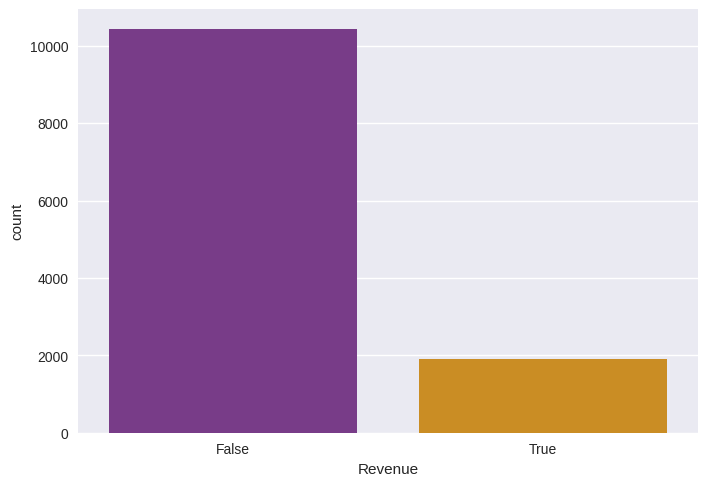

In [9]:
sns.countplot(x='Revenue', data=dummy_data, palette='CMRmap')
class_percent = dummy_data['Revenue'].value_counts(normalize=True) * 100
print('Sessions without purchase : {:.2f}%'.format(class_percent[0]))
print('Sessions with purchase: {:.2f}%'.format(class_percent[1]))

In [10]:
X, y = dummy_data.drop('Revenue', axis=1), dummy_data['Revenue']

Давайте заранее определимся, как мы будем производить контроль качества наших моделей:

Разделим выборку на тренировочную и тестовую.
Будем проводить кросс-валидацию на тренировочной выборке (то есть будем делить её на тренировочные и валидационные фолды и считать среднее значение метрики по фолдам).
Итого мы будем использовать три показателя:

значение метрики на тренировочных и валидационных фолдах кросс-валидации (по ним мы будем отслеживать переобучение модели и подбирать внешние параметры);
значение метрики на отложенной тестовой выборке (оно будет нашим контрольным показателем).
Другими словами, мы будем сочетать hold-оut- и k-fold-подходы к валидации.

# Задание 6.2

Для начала позаботимся о создании отложенной тестовой выборки.

Разделите выборку на тренировочную и тестовую в соотношении 80/20. Используйте разбиение, стратифицированное по целевому признаку. В качестве значения параметра random_state возьмите число 42.

Чему равно количество сессий на сайте в тренировочной и тестовой выборках?

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (9864, 28) (9864,)
Test: (2466, 28) (2466,)


# Задание 6.3

Коллеги посоветовали нам использовать случайный лес (Random Forest) для решения данной задачи. Давайте последуем их совету.

Создайте модель случайного леса. В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

Оцените качество такой модели с помощью кросс-валидации по пяти фолдам. Так как классы несбалансированы, используйте кросс-валидатор StratifiedKFold (перемешивать выборку не нужно).

Для проведения кросс-валидации используйте функцию cross_validate(). Набор данных (параметры X, y) — тренировочная выборка (X_train, y_train). Метрика — \(F_{1}\)-score.

Чему равно среднее значение метрики \(F_{1}\) на тренировочных и валидационных фолдах? Ответ округлите до двух знаков после точки-разделителя.

In [15]:
from sklearn import ensemble #ансамбли
# Создаём объект класса RandomForestClassifier
rf = ensemble.RandomForestClassifier(random_state=42)

# Обучаем модель 
rf.fit(X_train, y_train);

In [28]:
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=False)

#Считаем метрики на кросс-валидации StratifiedKFold
cv_metrics = model_selection.cross_validate(
    estimator=rf, #модель
    X=X_train, #матрица наблюдений X
    y=y_train, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([3.03607845, 3.37218761, 3.10531545, 2.53399634, 2.60228324]),
 'score_time': array([0.19629383, 0.23460293, 0.13538742, 0.13602781, 0.1184833 ]),
 'test_score': array([0.56750572, 0.6733871 , 0.49512671, 0.56463596, 0.37765539]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [29]:
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 1.00
Valid k-fold mean f1: 0.54


# Задание 6.5

Попробуем использовать несколько вариаций случайного леса и с помощью кривых обучения постараемся выбрать наилучшую из них.

Создайте список из трёх следующих моделей:

Случайный лес из деревьев максимальной глубины 5.
Случайный лес из деревьев максимальной глубины 7.
Случайный лес из деревьев максимальной глубины 12.
Для всех трёх моделей количество деревьев в лесу (n_estimators) возьмите равным 200, количество объектов в листе (min_samples_leaf) — 5. Параметр random_state = 42. Остальные параметры оставьте по умолчанию.

Постройте для каждой из моделей кривую обучения.

Совет: воспользуйтесь функцией plot_learning_curve(), которую мы создали в юните по кривым обучения.

Для построения кривых используйте обучающий набор данных (X_train, y_train), стратифицированный кросс-валидатор на пяти фолдов (StratifiedKFold) и метрику \(F_{1}\)-score. Остальные параметры функции learning_curve() оставьте по умолчанию.

Из построенных кривых обучения сделайте вывод: какая глубина деревьев в лесу является оптимальной?

In [34]:
models = [
    ensemble.RandomForestClassifier(max_depth=5, n_estimators=200, min_samples_leaf=5, random_state=42),
    ensemble.RandomForestClassifier(max_depth=7, n_estimators=200, min_samples_leaf=5, random_state=42),
    ensemble.RandomForestClassifier(max_depth=12, n_estimators=200, min_samples_leaf=5, random_state=42)
]

In [33]:
def plot_learning_curve(model, X, y, cv, scoring="f1", ax=None, title=""):
    # Вычисляем координаты для построения кривой обучения
    train_sizes, train_scores, valid_scores = model_selection.learning_curve(
        estimator=model,  # модель
        X=X,  # матрица наблюдений X
        y=y,  # вектор ответов y
        cv=cv,  # кросс-валидатор
        scoring=scoring,  # метрика
    )
    # Вычисляем среднее значение по фолдам для каждого набора данных
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    # Если координатной плоскости не было передано, создаём новую
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))  # фигура + координатная плоскость
    # Строим кривую обучения по метрикам на тренировочных фолдах
    ax.plot(train_sizes, train_scores_mean, label="Train")
    # Строим кривую обучения по метрикам на валидационных фолдах
    ax.plot(train_sizes, valid_scores_mean, label="Valid")
    # Даём название графику и подписи осям
    ax.set_title("Learning curve: {}".format(title))
    ax.set_xlabel("Train data size")
    ax.set_ylabel("Score")
    # Устанавливаем отметки по оси абсцисс
    ax.xaxis.set_ticks(train_sizes)
    # Устанавливаем диапазон оси ординат
    ax.set_ylim(0, 1)
    # Отображаем легенду
    ax.legend()

/home/vezdexod/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/vezdexod/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/vezdexod/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


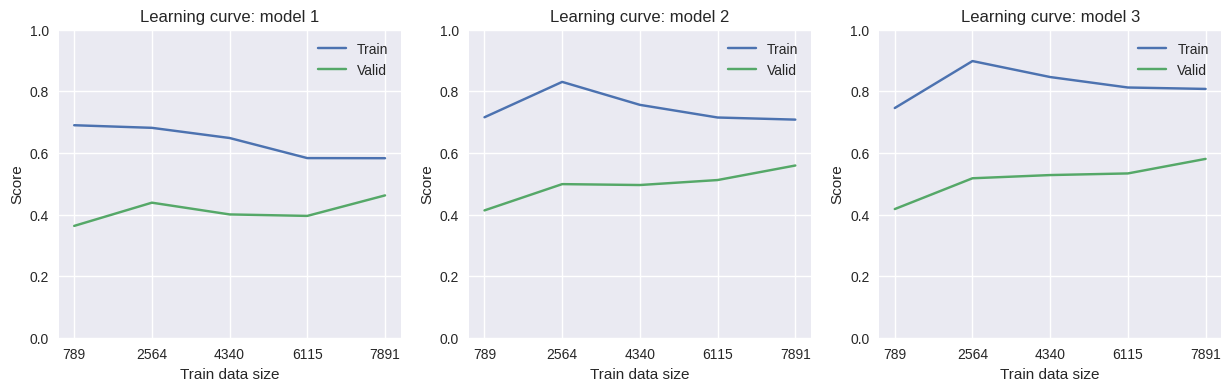

In [36]:
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Визуализируем кривые обучения
fig, axes = plt.subplots(1, 3, figsize=(15, 4)) #фигура + три координатных плоскости
#Создаём цикл по списку моделей и индексам этого списка
for i, model in enumerate(models): #i — текущий индекс, model — текущая модель
    plot_learning_curve(model, X_train, y_train, skf, ax=axes[i], title=f'model {i+1}')

In [47]:
# Создаём объект класса RandomForestClassifier
rf = ensemble.RandomForestClassifier(
    n_estimators=200, # число деревьев    
    max_depth=7, # максимальная глубина дерева
    min_samples_leaf=5, # минимальное число объектов в листе    
    random_state=42 # генератор случайных чисел
)

# Обучаем модель 
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, min_samples_leaf=5, n_estimators=200,
                       random_state=42)

In [48]:
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.93      0.98      0.95      8338
        True       0.86      0.57      0.68      1526

    accuracy                           0.92      9864
   macro avg       0.89      0.78      0.82      9864
weighted avg       0.92      0.92      0.91      9864

              precision    recall  f1-score   support

       False       0.91      0.98      0.94      2084
        True       0.79      0.49      0.60       382

    accuracy                           0.90      2466
   macro avg       0.85      0.73      0.77      2466
weighted avg       0.89      0.90      0.89      2466



# Задание 6.7

Попробуем повысить качество распознавания посетителей, совершивших покупку. Используем метод подбора порога вероятности с помощью PR-кривой.

Порог вероятности будем подбирать с помощью кросс-валидации.

Сделайте предсказание вероятностей принадлежности к пользователям, которые совершат покупку, на кросс-валидации на пяти фолдах. Используйте метод cross_val_predict().

Для кросс-валидации используйте случайный лес с подобранной в задании 6.5 максимальной глубиной деревьев, набор данных (параметры X, y) — тренировочная выборка (X_train, y_train).

Постройте PR-кривую и отметьте на ней точку, в которой наблюдается максимум метрики \(F_{1}\) для посетителей, которые совершат покупку. Определите порог вероятности, соответствующий этой точке.

В качестве ответа приведите значение выбранного порога вероятности. Ответ округлите до двух знаков после точки-разделителя.

Best threshold = 0.35, F1-Score = 0.69


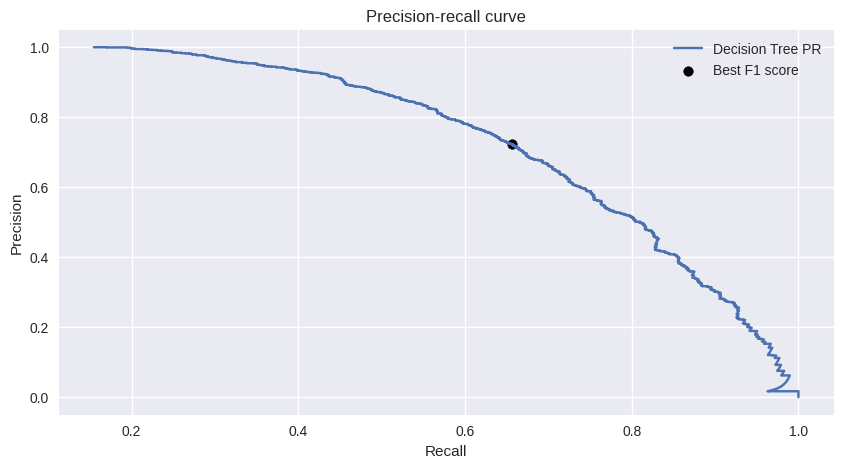

In [61]:
#Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')
#Выделяем столбец с вероятностями для класса 1 
y_cv_proba_pred = y_cv_proba_pred[:, 1]

#Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

#Вычисляем F1-score при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
#Определяем индекс максимума
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))
 
#Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим линейный график зависимости precision от recall
ax.plot(precision, recall, label='Decision Tree PR')
#Отмечаем точку максимума F1
ax.scatter(precision[idx], recall[idx], marker='o', color='black', label='Best F1 score')
#Даём графику название и подписываем оси
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
#Отображаем легенду
ax.legend();

# Задание 6.8

Сделайте предсказание классов объекта с определённым в предыдущем задании порогом вероятности. Выведите отчёт о метриках классификации.

Ответьте на следующие вопросы:

In [64]:
#Задаём оптимальный порог вероятностей
threshold_opt = 0.36
#Объекты, для которых вероятность быть классом 1 > threshold_opt, относим к классу 1
#В противном случае — к классу 0
y_test_pred_proba = rf.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_pred_proba > threshold_opt).astype('int')
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.94      0.93      0.94      2084
        True       0.66      0.69      0.67       382

    accuracy                           0.90      2466
   macro avg       0.80      0.81      0.81      2466
weighted avg       0.90      0.90      0.90      2466

